Check NA stuff


This script "attempts" to match entries if their authors intesect (not sure how well it's doing that or if it is even reasonable)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cProfile import label #?not sure
import re
from fuzzywuzzy import fuzz

/opt/homebrew/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
#removing space after authors 
def fix_author(row):
    if not isinstance(row, str) or row[-1] != ' ':
        return row
    return row[:-1]

In [7]:
#This is path to output csv files of the index of each book with they italicized names filtered out
vol1_path = '../input/input copy/index_without_itallics_csvs/vol1/vol1_index_pruned.csv'
vol2_path = '../input/input copy/index_without_itallics_csvs/vol2/vol2_index_pruned.csv'
vol3_path = '../input/input copy/index_without_itallics_csvs/vol3/vol3_index_pruned.csv'

vol1_df = pd.read_csv(vol1_path)
vol2_df = pd.read_csv(vol2_path)
vol3_df = pd.read_csv(vol3_path)

#fix spacing issue
vol1_df['author'] = vol1_df['author'].apply(fix_author)
vol2_df['author'] = vol2_df['author'].apply(fix_author)
vol3_df['author'] = vol3_df['author'].apply(fix_author)

#changing name of columns 
vol1_df.rename(columns={'genus': 'mouterde_genus', 'epithet': 'mouterde_epithet', 'author':'mouterde_author', 'infra':'mouterde_infra'}, inplace=True)
vol2_df.rename(columns={'genus': 'mouterde_genus', 'epithet': 'mouterde_epithet', 'author':'mouterde_author', 'infra':'mouterde_infra'}, inplace=True)
vol3_df.rename(columns={'genus': 'mouterde_genus', 'epithet': 'mouterde_epithet', 'author':'mouterde_author', 'infra':'mouterde_infra'}, inplace=True)

#wcvp 
text_wcvp_path = '../input/input copy/wcvp/wcvp_v9_jun_2022.txt'
wcvp_df = pd.read_csv(text_wcvp_path, sep = '|')

In [8]:
def get_set(x):
    if not isinstance(x, list): #is this the best way
        x = []
    return set(x)

#to use after exploding the authors
connectors = {'ex', '&'}
def remove_prantheses(x):
    if isinstance(x, str):
        return re.sub(r'([()])', '', x)
    return x

In [9]:
def process_wcvp(wcvp_df):
    wcvp_df['infraspecies'].replace(np.nan, 'np.NaN', inplace=True)
    wcvp_df['species'].replace(np.nan, 'np.NaN', inplace=True)
    wcvp_df['authors_set'] = wcvp_df['authors'].str.split(' ').apply(lambda x : get_set(x) - connectors)
    wcvp_df_explode = wcvp_df.explode('authors_set')
    wcvp_df_explode['authors_set'] = wcvp_df_explode['authors_set'].apply(remove_prantheses) #to remove prantheses
    return wcvp_df_explode

In [10]:
def get_overlapping_authors(mouterde_df, wcvp_df_explode):
    mouterde_df['mouterde_infra'].replace(np.nan, 'np.NaN', inplace=True)
    mouterde_df['mouterde_epithet'].replace(np.nan, 'np.NaN', inplace=True)
    mouterde_df['mouterde_author'] = mouterde_df['mouterde_author'].str.replace(' et ', ' & ')

    mouterde_df['authors_set'] = mouterde_df['mouterde_author'].str.split(' ').apply(lambda x : get_set(x) - connectors)
    mouterde_df_explode = mouterde_df.explode('authors_set')
    mouterde_df_explode['authors_set'] = mouterde_df_explode['authors_set'].apply(remove_prantheses) #to remove prantheses

    # had duplicates 
    merge_df = pd.merge(mouterde_df_explode, 
                        wcvp_df_explode, 
                        how='inner', 
                        left_on=['mouterde_genus','mouterde_epithet', 'mouterde_infra' , 'authors_set'], 
                        right_on = ['genus','species', 'infraspecies', 'authors_set'])

    merge_df_simplified = merge_df[['mouterde_genus', 'mouterde_epithet', 'mouterde_infra', 'mouterde_author', 'authors', 'taxonomic_status', 'accepted_name', 'accepted_authors']]
    return merge_df_simplified.drop_duplicates()

In [11]:
def get_miss_match(mouterde_df, merge_df):
    merge_df2 = pd.merge(mouterde_df, 
                         merge_df, 
                         how='left', 
                         left_on=['mouterde_genus','mouterde_epithet', 'mouterde_infra' , 'mouterde_author'], 
                         right_on = ['mouterde_genus','mouterde_epithet', 'mouterde_infra', 'mouterde_author'])

    merge_df2 = merge_df2[merge_df2['taxonomic_status'].isna()]

    merge_df2_simplified = merge_df2[['mouterde_genus', 'mouterde_epithet', 'mouterde_infra', 'mouterde_author', 'authors', 'taxonomic_status', 'accepted_name', 'accepted_authors']]
    return merge_df2_simplified

In [12]:
wcvp_df_explode = process_wcvp(wcvp_df)
vol1_wcvp_df_simplified = get_overlapping_authors(vol1_df, wcvp_df_explode)
vol2_wcvp_df_simplified = get_overlapping_authors(vol2_df, wcvp_df_explode)
vol3_wcvp_df_simplified = get_overlapping_authors(vol3_df, wcvp_df_explode)

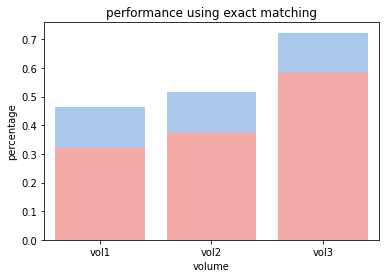

In [13]:
pick_up_rates = [vol1_wcvp_df_simplified.shape[0]/vol1_df.shape[0],
                 vol2_wcvp_df_simplified.shape[0]/vol2_df.shape[0],
                 vol3_wcvp_df_simplified.shape[0]/vol3_df.shape[0]]
accepted_rate = [(vol1_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol1_df.shape[0],
                 (vol2_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol2_df.shape[0],
                 (vol3_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol3_df.shape[0]]

ax = plt.subplots()

pastel_blue = sns.color_palette("pastel")[0]
pastel_red = sns.color_palette("pastel")[3]

ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=pick_up_rates, color=pastel_blue, label = 'percentage picked up')
ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=accepted_rate, color=pastel_red, label = 'percentage accepted')

ax.set(xlabel="volume", ylabel="percentage", title = "performance using exact matching")

#plt.legend()
plt.show()

In [14]:
pick_up_rates

[0.46359048305695744, 0.5146958304853042, 0.7231812577065352]

In [15]:
vol1_wcvp_missed_df_simplified = get_miss_match(vol1_df, vol1_wcvp_df_simplified)
vol2_wcvp_missed_df_simplified = get_miss_match(vol2_df, vol2_wcvp_df_simplified)
vol3_wcvp_missed_df_simplified = get_miss_match(vol3_df, vol3_wcvp_df_simplified)

In [16]:
vol1_wcvp_missed_df_simplified

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acanthophyllum,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
2,Achyranthes,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
4,Adiantum,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
6,Aegilops,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
12,Aegilops,juvenali∫,np.NaN,Thell.,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1375,Viscum,cruciatum,np.NaN,Sieb.,NaN,NaN,NaN,NaN
1376,Vulpia,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
1377,Vulpia,ciliata,np.NaN,(Pers.) Link,NaN,NaN,NaN,NaN
1384,Zannichellia,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
vol2_wcvp_missed_df_simplified

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acacia,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
1,Acacia,albida,np.NaN,Del.,NaN,NaN,NaN,NaN
3,Acer,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
6,Acer,tauricolum,np.NaN,Boiss. & Bal.,NaN,NaN,NaN,NaN
7,Actinolema,np.NaN,np.NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1454,Ranunculus,macrorrhynchup,np.NaN,Boiss.-,NaN,NaN,NaN,NaN
1455,Ranunculus,marginaţus,np.NaN,d'Urv.,NaN,NaN,NaN,NaN
1460,Ranunculus,neapolitanus,np.NaN,Ten,NaN,NaN,NaN,NaN
1462,Ranunculus,orbiculatus,np.NaN,Boiss. & Bo.,NaN,NaN,NaN,NaN


In [18]:
vol3_wcvp_missed_df_simplified

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acantholepis,np.NaN,np.NaN,Less.',NaN,NaN,NaN,NaN
4,Acantholimon,antilibanoticum,np.NaN,Mout.,NaN,NaN,NaN,NaN
15,Achillea,biebersteinii,np.NaN,Afan.,NaN,NaN,NaN,NaN
22,Achillea,wilhelmsii,np.NaN,C. Koch,NaN,NaN,NaN,NaN
26,Ajuga,chasmophila,np.NaN,Davis,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1618,Xeranthemum,longipapposum,np.NaN,Fisch. & Mey.,NaN,NaN,NaN,NaN
1620,Ziziphora,'Abd-el-'asissi,np.NaN,Hand.-Mazz.,NaN,NaN,NaN,NaN
1621,Ziziphora,acutifolia,np.NaN,Montb. & Auch.,NaN,NaN,NaN,NaN
1624,Ziziphora,capitata,orientalis,Sam. ex Rech. fil.,NaN,NaN,NaN,NaN


In [19]:
# example of a weird situation
genus = "Ajuga"
species = "chasmophila"
wcvp_df[(wcvp_df['genus'] == genus) & (wcvp_df['species'] == species)]

# author = 'Davis'
# wcvp_df[(wcvp_df['authors'] == author)]

,kew_id,family,genus,species,infraspecies,taxon_name,authors,rank,taxonomic_status,accepted_kew_id,accepted_name,accepted_authors,parent_kew_id,parent_name,parent_authors,reviewed,publication,original_name_id,authors_set
639632,444548-1,Lamiaceae,Ajuga,chasmophila,np.NaN,Ajuga chasmophila,P.H.Davis,SPECIES,Accepted,NaN,NaN,NaN,20646-1,Ajuga,L.,Reviewed,Kew Bull. 2: 64 (1947),NaN,{P.H.Davis}


In [20]:
vol1_df

,page_num,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,taxon rank,authors_set
0,616,Acanthophyllum,np.NaN,np.NaN,NaN,genus,{}
1,616,Acanthophyllum,kurdicum,np.NaN,Boiss. & Hausskn.,species,"{Boiss., Hausskn.}"
2,616,Achyranthes,np.NaN,np.NaN,NaN,genus,{}
3,616,Achyranthes,aspera,np.NaN,L.,species,{L.}
4,616,Adiantum,np.NaN,np.NaN,NaN,genus,{}
...,...,...,...,...,...,...,...
1382,638,Vulpia,uniglumis,np.NaN,(Sol.) Dumort.,species,"{(Sol.), Dumort.}"
1383,638,Zannichellia,np.NaN,np.NaN,NaN,genus,{}
1384,638,Zannichellia,palustris,np.NaN,L.,species,{L.}
1385,638,Zostera,np.NaN,np.NaN,NaN,genus,{}


In [21]:
import difflib 


In [22]:
from fuzzywuzzy import process
def get_closest_match(r):
    m_author = r['mouterde_author'] 
    genus = r['mouterde_genus']
    epithet = r['mouterde_epithet']
    infra = r['mouterde_infra']
    wcvp_df_gs_match = wcvp_df[(wcvp_df['genus'] == genus) & (wcvp_df['species'] == epithet) & (wcvp_df['infraspecies'] == infra)]
    try:
        author_match = process.extract(m_author, wcvp_df_gs_match['authors'])[0][0]
    except:
        author_match = np.nan
    #author_match = difflib.get_close_matches(m_author, wcvp_df_gs_match['authors'])
    return author_match

In [23]:
vol3_df['closest_wcvp_match'] = vol3_df.apply(get_closest_match, axis = 1)

In [21]:
from tqdm.auto import tqdm
tqdm.pandas()

In [24]:
def get_overlapping_authors2(processed_mouterde_df, wcvp_df):
    #assuming the closest wcvp already in processed_mouterde_df
    #mouterde_df['mouterde_infra'].replace(np.nan, 'np.NaN', inplace=True)
    #mouterde_df['mouterde_epithet'].replace(np.nan, 'np.NaN', inplace=True)
    #mouterde_df['mouterde_author'] = mouterde_df['mouterde_author'].str.replace(' et ', ' & ')

    #mouterde_df['authors_set'] = mouterde_df['mouterde_author'].str.split(' ').apply(lambda x : get_set(x) - connectors)
    #mouterde_df_explode = mouterde_df.explode('authors_set')
    #mouterde_df_explode['authors_set'] = mouterde_df_explode['authors_set'].apply(remove_prantheses) #to remove prantheses

    # had duplicates 
    merge_df = pd.merge(processed_mouterde_df, 
                        wcvp_df_explode, 
                        how='inner', 
                        left_on=['mouterde_genus','mouterde_epithet', 'mouterde_infra' , 'closest_wcvp_match'], 
                        right_on = ['genus','species', 'infraspecies', 'authors'])

    merge_df_simplified = merge_df[['mouterde_genus', 'mouterde_epithet', 'mouterde_infra', 'mouterde_author', 'authors', 'taxonomic_status', 'accepted_name', 'accepted_authors']]
    return merge_df_simplified#.drop_duplicates() #for some reason there are duplicates and I have no idea why

In [25]:
result = get_overlapping_authors2(vol3_df, wcvp_df)
result[result.duplicated(keep=False)].head(60)

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
3,Acantholimon,acerosum,np.NaN,(Willd.) Boiss.,(Willd.) Boiss.,Accepted,NaN,NaN
4,Acantholimon,acerosum,np.NaN,(Willd.) Boiss.,(Willd.) Boiss.,Accepted,NaN,NaN
8,Acantholimon,ulicinum,np.NaN,(Schultes) Boiss.,(Willd. ex Schult.) Boiss.,Accepted,NaN,NaN
9,Acantholimon,ulicinum,np.NaN,(Schultes) Boiss.,(Willd. ex Schult.) Boiss.,Accepted,NaN,NaN
10,Acantholimon,ulicinum,np.NaN,(Schultes) Boiss.,(Willd. ex Schult.) Boiss.,Accepted,NaN,NaN
21,Achillea,fragrantissima,np.NaN,(Forssk.) Schultz Bip.,(Forssk.) Sch.Bip.,Accepted,NaN,NaN
22,Achillea,fragrantissima,np.NaN,(Forssk.) Schultz Bip.,(Forssk.) Sch.Bip.,Accepted,NaN,NaN
28,Aetheorhiza,bulbosa,np.NaN,(L.) Cass.,(L.) Cass.,Accepted,NaN,NaN
29,Aetheorhiza,bulbosa,np.NaN,(L.) Cass.,(L.) Cass.,Accepted,NaN,NaN
36,Ajuga,tridactylites,np.NaN,Gingins ex Benth.,Ging. ex Benth.,Homotypic_Synonym,Ajuga chamaepitys subsp. tridactylites,(Ging. ex Benth.) P.H.Davis


In [26]:
len(result.drop_duplicates())/len(vol3_df)

0.8495684340320592

In [27]:
vol1_df['closest_wcvp_match'] = vol1_df.apply(get_closest_match, axis = 1)

result1 = get_overlapping_authors2(vol1_df, wcvp_df)
result1[result1.duplicated(keep=False)].head(60)
len(result1.drop_duplicates())/len(vol1_df)

0.6027397260273972

In [28]:
missing_vol1 = vol1_df[~((vol1_df['mouterde_genus'].isin(result1['mouterde_genus'])) & (vol1_df['mouterde_epithet'].isin(result1['mouterde_epithet'])) & (vol1_df['mouterde_infra'].isin(result1['mouterde_infra'])) & (vol1_df['mouterde_author'].isin(result1['mouterde_author'])))]

In [29]:
missing_vol1[~missing_vol1['mouterde_author'].isna()]

,page_num,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,taxon rank,authors_set,closest_wcvp_match
12,616,Aegilops,juvenali∫,np.NaN,Thell.,species,{Thell.},NaN
17,616,Aegilops,peregrina(Hack.),np.NaN,Maire & Weiller,species,"{Weiller, Maire}",NaN
22,616,Aegilops,umbeUulata,np.NaN,Zhuk.,species,{Zhuk.},NaN
25,616,Aegilotricum,loreti,np.NaN,(Richt.) Maire & Weiller,species,"{Weiller, (Richt.), Maire}",NaN
27,616,Aellenia,glauc,np.NaN,(Bieb.) Aellen,species,"{(Bieb.), Aellen}",NaN
...,...,...,...,...,...,...,...,...
1312,636,Thelygonum,cynocrambe,np.NaN,L.,species,{L.},NaN
1328,637,Trisetaria,kœlerioides,np.NaN,(Bornm. & Hack.),species,"{Hack.), (Bornm.}",NaN
1336,637,Tulipa,auCheriana,np.NaN,Baker,species,{Baker},NaN
1349,637,—latifolia,laxmannii,np.NaN,Lepechin,species,{Lepechin},NaN


In [30]:
vol2_df['closest_wcvp_match'] = vol2_df.apply(get_closest_match, axis = 1)

result2 = get_overlapping_authors2(vol2_df, wcvp_df)
result2[result2.duplicated(keep=False)].head(60)
len(result2.drop_duplicates())/len(vol2_df)

0.6630211893369788

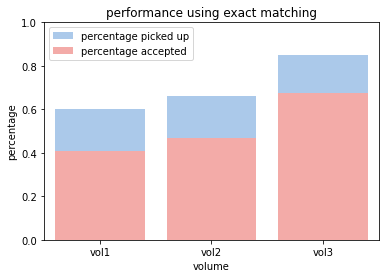

In [31]:
vol1_wcvp_df_simplified = result1.drop_duplicates()
vol2_wcvp_df_simplified = result2.drop_duplicates()
vol3_wcvp_df_simplified = result.drop_duplicates()
pick_up_rates = [vol1_wcvp_df_simplified.shape[0]/vol1_df.shape[0],
                 vol2_wcvp_df_simplified.shape[0]/vol2_df.shape[0],
                 vol3_wcvp_df_simplified.shape[0]/vol3_df.shape[0]]

accepted_rate = [(vol1_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol1_df.shape[0],
                 (vol2_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol2_df.shape[0],
                 (vol3_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol3_df.shape[0]]

ax = plt.subplots()

pastel_blue = sns.color_palette("pastel")[0]
pastel_red = sns.color_palette("pastel")[3]

ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=pick_up_rates, color=pastel_blue, label = 'percentage picked up')
ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=accepted_rate, color=pastel_red, label = 'percentage accepted')

ax.set(xlabel="volume", ylabel="percentage", title = "performance using exact matching", ylim = (0,1))

plt.legend()
plt.show()

## MATCHING WITHOUT AUTHOR

In [30]:
def get_overlapping_authors3(processed_mouterde_df, wcvp_df):
    #assuming the closest wcvp already in processed_mouterde_df
    #mouterde_df['mouterde_infra'].replace(np.nan, 'np.NaN', inplace=True)
    #mouterde_df['mouterde_epithet'].replace(np.nan, 'np.NaN', inplace=True)
    #mouterde_df['mouterde_author'] = mouterde_df['mouterde_author'].str.replace(' et ', ' & ')

    #mouterde_df['authors_set'] = mouterde_df['mouterde_author'].str.split(' ').apply(lambda x : get_set(x) - connectors)
    #mouterde_df_explode = mouterde_df.explode('authors_set')
    #mouterde_df_explode['authors_set'] = mouterde_df_explode['authors_set'].apply(remove_prantheses) #to remove prantheses

    # had duplicates 
    merge_df = pd.merge(processed_mouterde_df, 
                        wcvp_df_explode, 
                        how='inner', 
                        left_on=['mouterde_genus','mouterde_epithet', 'mouterde_infra'], 
                        right_on = ['genus','species', 'infraspecies'])

    merge_df_simplified = merge_df[['mouterde_genus', 'mouterde_epithet', 'mouterde_infra', 'mouterde_author']]
    return merge_df_simplified.drop_duplicates()

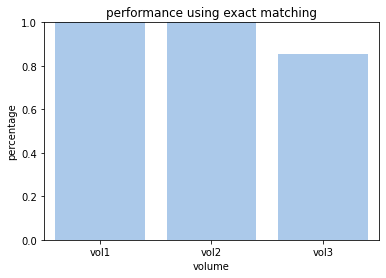

In [58]:
vol1_wcvp_df_simplified = get_overlapping_authors3(vol1_df, wcvp_df)
vol2_wcvp_df_simplified = get_overlapping_authors3(vol2_df, wcvp_df)
vol3_wcvp_df_simplified = get_overlapping_authors3(vol3_df, wcvp_df)
pick_up_rates = [vol1_wcvp_df_simplified.shape[0]/vol1_df[~(vol1_df['mouterde_epithet'] == 'np.NaN')].shape[0],
                 vol2_wcvp_df_simplified.shape[0]/vol2_df[~(vol2_df['mouterde_epithet'] == 'np.NaN')].shape[0],
                 vol3_wcvp_df_simplified.shape[0]/vol3_df.shape[0]]

# accepted_rate = [(vol1_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol1_df.shape[0],
#                  (vol2_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol2_df.shape[0],
#                  (vol3_wcvp_df_simplified['taxonomic_status'] == 'Accepted').sum()/vol3_df.shape[0]]

ax = plt.subplots()

pastel_blue = sns.color_palette("pastel")[0]
pastel_red = sns.color_palette("pastel")[3]

ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=pick_up_rates, color=pastel_blue, label = 'percentage picked up')
# ax = sns.barplot(x=['vol1', 'vol2', 'vol3'], y=accepted_rate, color=pastel_red, label = 'percentage accepted')

ax.set(xlabel="volume", ylabel="percentage", title = "performance using exact matching", ylim=(0,1))

plt.show()

In [56]:
pick_up_rates

[1.0618556701030928, 1.1120840630472855, 0.8538840937114673]

In [61]:
vol3_df[['mouterde_author', 'closest_wcvp_match']].head(50)

,mouterde_author,closest_wcvp_match
0,Less.',Less.
1,Less.,Less.
2,Boiss.,Boiss.
3,(Willd.) Boiss.,(Willd.) Boiss.
4,Mout.,Mouterde
5,Mobayen,Mobayen
6,Boiss.,Boiss.
7,(Schultes) Boiss.,(Willd. ex Schult.) Boiss.
8,L.,L.
9,L.,L.


In [33]:
vol1_df[['mouterde_genus','mouterde_epithet']].drop_duplicates()

,mouterde_genus,mouterde_epithet
0,Acanthophyllum,np.NaN
1,Acanthophyllum,kurdicum
2,Achyranthes,np.NaN
3,Achyranthes,aspera
4,Adiantum,np.NaN
...,...,...
1382,Vulpia,uniglumis
1383,Zannichellia,np.NaN
1384,Zannichellia,palustris
1385,Zostera,np.NaN


In [46]:
result1.head(-50)

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acanthophyllum,kurdicum,np.NaN,Boiss. & Hausskn.,Boiss. & Hausskn.,Synonym,Acanthophyllum crassifolium,Boiss.
2,Achyranthes,aspera,np.NaN,L.,L.,Accepted,NaN,NaN
3,Adiantum,capillus-veneris,np.NaN,L.,L.,Accepted,NaN,NaN
4,Aegilops,biuncialis,np.NaN,Vis.,Vis.,Accepted,NaN,NaN
5,Aegilops,caudata,np.NaN,L.,L.,Accepted,NaN,NaN
...,...,...,...,...,...,...,...,...
1117,Suaeda,asphaltica,np.NaN,Boiss.,(Boiss.) Boiss.,Accepted,NaN,NaN
1119,Suaeda,carnosissima,np.NaN,Post,Post,Accepted,NaN,NaN
1120,Suaeda,fruticosa,np.NaN,(L.) Forsk.,Forssk. ex J.F.Gmel.,Accepted,NaN,NaN
1122,Suaeda,prostrata,np.NaN,Pali.,Pall.,Accepted,NaN,NaN


In [32]:
result1 = result1.drop_duplicates()
result1.to_csv("../output/fuzzy_matching/index/authors_fuzzy_matched_vol1.csv", encoding = 'utf-8-sig')

OSError: Cannot save file into a non-existent directory: '../output/fuzzy_matching/index'

In [ ]:
result = result.drop_duplicates()
result.to_csv("../output/fuzzy_matching/index/authors_fuzzy_matched_vol3.csv", encoding = 'utf-8-sig')

In [ ]:
result2 = result2.drop_duplicates()
result2.to_csv("../output/fuzzy_matching/index/authors_fuzzy_matched_vol2.csv", encoding = 'utf-8-sig')

## what is missing?

In [38]:
def get_overlapping_authors3_missing(processed_mouterde_df, wcvp_df):
    #assuming the closest wcvp already in processed_mouterde_df
    #mouterde_df['mouterde_infra'].replace(np.nan, 'np.NaN', inplace=True)
    #mouterde_df['mouterde_epithet'].replace(np.nan, 'np.NaN', inplace=True)
    #mouterde_df['mouterde_author'] = mouterde_df['mouterde_author'].str.replace(' et ', ' & ')

    #mouterde_df['authors_set'] = mouterde_df['mouterde_author'].str.split(' ').apply(lambda x : get_set(x) - connectors)
    #mouterde_df_explode = mouterde_df.explode('authors_set')
    #mouterde_df_explode['authors_set'] = mouterde_df_explode['authors_set'].apply(remove_prantheses) #to remove prantheses

    # had duplicates 
    merge_df = pd.merge(processed_mouterde_df, 
                        wcvp_df_explode, 
                        how='left', 
                        left_on=['mouterde_genus','mouterde_epithet', 'mouterde_infra'], 
                        right_on = ['genus','species', 'infraspecies'])

    #merge_df[merge_df['genus'] != np.nan]
    return merge_df
    merge_df_simplified = merge_df[['mouterde_genus', 'mouterde_epithet', 'mouterde_infra', 'mouterde_author']]
    return merge_df_simplified.drop_duplicates()

result4 = get_overlapping_authors3_missing(vol1_df, wcvp_df)
result4[result4['kew_id'].isna()]

,page_num,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,taxon rank,authors_set_x,closest_wcvp_match,kew_id,family,...,accepted_kew_id,accepted_name,accepted_authors,parent_kew_id,parent_name,parent_authors,reviewed,publication,original_name_id,authors_set_y
17,616,Aegilops,juvenali∫,np.NaN,Thell.,species,{Thell.},NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,616,Aegilops,peregrina(Hack.),np.NaN,Maire & Weiller,species,"{Maire, Weiller}",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,616,Aegilops,umbeUulata,np.NaN,Zhuk.,species,{Zhuk.},NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,616,Aegilotricum,loreti,np.NaN,(Richt.) Maire & Weiller,species,"{Maire, Weiller, (Richt.)}",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,616,Aellenia,glauc,np.NaN,(Bieb.) Aellen,species,"{(Bieb.), Aellen}",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,637,—latifolia,L.,np.NaN,NaN,species,{},NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028,637,—latifolia,laxmannii,np.NaN,Lepechin,species,{Lepechin},NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,637,minor,np.NaN,np.NaN,NaN,genus,{},NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034,637,minor,Mill.,np.NaN,NaN,species,{},NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
result1 # why do duplicates even exist here

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acanthophyllum,kurdicum,np.NaN,Boiss. & Hausskn.,Boiss. & Hausskn.,Synonym,Acanthophyllum crassifolium,Boiss.
1,Acanthophyllum,kurdicum,np.NaN,Boiss. & Hausskn.,Boiss. & Hausskn.,Synonym,Acanthophyllum crassifolium,Boiss.
2,Achyranthes,aspera,np.NaN,L.,L.,Accepted,NaN,NaN
3,Adiantum,capillus-veneris,np.NaN,L.,L.,Accepted,NaN,NaN
4,Aegilops,biuncialis,np.NaN,Vis.,Vis.,Accepted,NaN,NaN
...,...,...,...,...,...,...,...,...
1187,Vulpia,myuros,np.NaN,(L.) C. C. Gmel.,(L.) C.C.Gmel.,Homotypic_Synonym,Festuca myuros,L.
1188,Vulpia,myuros,np.NaN,(L.) C. C. Gmel.,(L.) C.C.Gmel.,Homotypic_Synonym,Festuca myuros,L.
1189,Vulpia,uniglumis,np.NaN,(Sol.) Dumort.,Dumort.,Synonym,Festuca bromoides,L.
1190,Zannichellia,palustris,np.NaN,L.,L.,Accepted,NaN,NaN


# ^ END OF Oct 26

In [47]:
result.head(50)

,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,authors,taxonomic_status,accepted_name,accepted_authors
0,Acantholepis,np.NaN,np.NaN,Less.',Less.,Synonym,Echinops,L.
1,Acantholepis,orientalis,np.NaN,Less.,Less.,Homotypic_Synonym,Echinops acantholepis,Jaub. & Spach
2,Acantholimon,np.NaN,np.NaN,Boiss.,Boiss.,Accepted,NaN,NaN
3,Acantholimon,acerosum,np.NaN,(Willd.) Boiss.,(Willd.) Boiss.,Accepted,NaN,NaN
5,Acantholimon,antilibanoticum,np.NaN,Mout.,Mouterde,Accepted,NaN,NaN
6,Acantholimon,damassanum,np.NaN,Mobayen,Mobayen,Accepted,NaN,NaN
7,Acantholimon,libanoticum,np.NaN,Boiss.,Boiss.,Accepted,NaN,NaN
8,Acantholimon,ulicinum,np.NaN,(Schultes) Boiss.,(Willd. ex Schult.) Boiss.,Accepted,NaN,NaN
11,Acanthus,np.NaN,np.NaN,L.,L.,Accepted,NaN,NaN
12,Acanthus,dioscoridis,np.NaN,L.,L.,Accepted,NaN,NaN


In [1]:
vol3_df[vol3_df['closest_wcvp_match'].isna()].head(50)

NameError: name 'vol3_df' is not defined

In [136]:
wcvp_df[(wcvp_df['genus'] == 'Calhpeltis') & (wcvp_df['species'] == 'cucullaris')]

,kew_id,family,genus,species,infraspecies,taxon_name,authors,rank,taxonomic_status,accepted_kew_id,accepted_name,accepted_authors,parent_kew_id,parent_name,parent_authors,reviewed,publication,original_name_id,authors_set


In [115]:
vol3_df

,page_num,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,taxon rank,authors_set,closest_wcvp_match
0,555,Acantholepis,np.NaN,np.NaN,Less.',genus,{Less.'},Less.
1,555,Acantholepis,orientalis,np.NaN,Less.,species,{Less.},Less.
2,555,Acantholimon,np.NaN,np.NaN,Boiss.,genus,{Boiss.},Boiss.
3,555,Acantholimon,acerosum,np.NaN,(Willd.) Boiss.,species,"{(Willd.), Boiss.}",(Willd.) Boiss.
4,555,Acantholimon,antilibanoticum,np.NaN,Mout.,species,{Mout.},Mouterde
...,...,...,...,...,...,...,...,...
1617,582,Ziziphora,taurica,np.NaN,Bieb.,species,{Bieb.},M.Bieb.
1618,582,Ziziphora,tenuior,np.NaN,L.,species,{L.},L.
1619,582,Zoegea,np.NaN,np.NaN,L.,genus,{L.},L.
1620,582,Zoegea,leptaurea,np.NaN,L.,species,{L.},L.


In [71]:
get_close_match(vol3_df.iloc[10])

['L.']

In [76]:
vol1_df.iloc[2]['mouterde_author']

nan

In [108]:
wcvp_df

,kew_id,family,genus,species,infraspecies,taxon_name,authors,rank,taxonomic_status,accepted_kew_id,accepted_name,accepted_authors,parent_kew_id,parent_name,parent_authors,reviewed,publication,original_name_id,authors_set
0,338-1,Acanthaceae,Acanthodium,np.NaN,np.NaN,Acanthodium,Delile,GENUS,Synonym,427-1,Blepharis,Juss.,NaN,NaN,NaN,In review,"Descr. Egypte, Hist. Nat. 2(Mém.): 241 (1813)",NaN,{Delile}
1,44787-1,Acanthaceae,Acanthodium,angustum,np.NaN,Acanthodium angustum,Nees,SPECIES,Homotypic_Synonym,46469-1,Blepharis angusta,(Nees) T.Anderson,NaN,NaN,NaN,In review,"A.P.de Candolle, Prodr. 11: 273 (1847)",NaN,{Nees}
2,44788-1,Acanthaceae,Acanthodium,capense,np.NaN,Acanthodium capense,(L.f.) Nees,SPECIES,Homotypic_Synonym,46487-1,Blepharis capensis,(L.f.) Pers.,NaN,NaN,NaN,In review,Linnaea 15: 361 (1841),NaN,"{(L.f.), Nees}"
3,44789-1,Acanthaceae,Acanthodium,carduifolium,np.NaN,Acanthodium carduifolium,(L.f.) Nees,SPECIES,Homotypic_Synonym,44830-1,Acanthopsis carduifolia,(L.f.) Schinz,NaN,NaN,NaN,In review,"A.P.de Candolle, Prodr. 11: 278 (1847)",44848-1,"{(L.f.), Nees}"
4,44790-1,Acanthaceae,Acanthodium,delilii,np.NaN,Acanthodium delilii,H.Buek,SPECIES,Synonym,46503-1,Blepharis edulis,(Forssk.) Pers.,NaN,NaN,NaN,In review,Gen. Sp. Candoll. 3: 1 (1858),NaN,{H.Buek}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232926,873721-1,Zygophyllaceae,Zygophyllum,webbianum,np.NaN,Zygophyllum webbianum,Coss.,SPECIES,Synonym,873565-1,Zygophyllum fontanesii,Webb & Berthel.,NaN,NaN,NaN,In review,Bull. Soc. Bot. France 2: 365 (1855),NaN,{Coss.}
1232927,77205534-1,Zygophyllaceae,Zygophyllum,xanthoxylum,np.NaN,Zygophyllum xanthoxylum,(Bunge) Maxim.,SPECIES,Accepted,NaN,NaN,NaN,41749-1,Zygophyllum,L.,In review,Fl. Tangut.: 103 (1889),873370-1,"{(Bunge), Maxim.}"
1232928,873723-1,Zygophyllaceae,Zygophyllum,zanthoxylum,np.NaN,Zygophyllum zanthoxylum,Engl. ex Dippel,SPECIES,Synonym,77205534-1,Zygophyllum xanthoxylum,(Bunge) Maxim.,NaN,NaN,NaN,In review,Handb. Laubholzk. 2: 358 (1893),NaN,"{Dippel, Engl.}"
1232929,77184991-1,Zygophyllaceae,Zygophyllum,zilloides,np.NaN,Zygophyllum zilloides,(Humbert) Christenh. & Byng,SPECIES,Accepted,NaN,NaN,NaN,41749-1,Zygophyllum,L.,In review,Global Fl. 4: 93 (2018),873235-1,"{(Humbert), Christenh., Byng}"


In [22]:
genus = 'Aegilops'
epithet = 'crassa'
infra = 'np.NaN'
wcvp_df[(wcvp_df['genus'] == genus) & (wcvp_df['species'] == epithet) & (wcvp_df['infraspecies'] == infra)]

,kew_id,family,genus,species,infraspecies,taxon_name,authors,rank,taxonomic_status,accepted_kew_id,accepted_name,accepted_authors,parent_kew_id,parent_name,parent_authors,reviewed,publication,original_name_id,authors_set
930586,384576-1,Poaceae,Aegilops,crassa,np.NaN,Aegilops crassa,Boiss. ex Hohen.,SPECIES,Accepted,NaN,NaN,NaN,17369-1,Aegilops,L.,Reviewed,Exsicc. (Pl. Pers. Austr.) 1842: n.° 248 (1845),NaN,"{Hohen., Boiss.}"


In [23]:
vol1_df.apply(get_close_match, axis = 1)

TypeError: 'float' object is not iterable

In [ ]:
vol1_df

,page_num,mouterde_genus,mouterde_epithet,mouterde_infra,mouterde_author,taxon rank,authors_set
0,616,Acanthophyllum,np.NaN,np.NaN,NaN,genus,{}
1,616,Acanthophyllum,kurdicum,np.NaN,Boiss. & Hausskn.,species,"{Boiss., Hausskn.}"
2,616,Achyranthes,np.NaN,np.NaN,NaN,genus,{}
3,616,Achyranthes,aspera,np.NaN,L.,species,{L.}
4,616,Adiantum,np.NaN,np.NaN,NaN,genus,{}
...,...,...,...,...,...,...,...
1382,638,Vulpia,uniglumis,np.NaN,(Sol.) Dumort.,species,"{(Sol.), Dumort.}"
1383,638,Zannichellia,np.NaN,np.NaN,NaN,genus,{}
1384,638,Zannichellia,palustris,np.NaN,L.,species,{L.}
1385,638,Zostera,np.NaN,np.NaN,NaN,genus,{}


In [65]:
r = vol3_df.iloc[165]
r

page_num                  558
mouterde_genus      Bellardia
mouterde_epithet       np.NaN
mouterde_infra         np.NaN
mouterde_author          Ail.
taxon rank              genus
authors_set            {Ail.}
Name: 165, dtype: object

In [68]:
genus = r['mouterde_genus']
epithet = r['mouterde_epithet']
infra = r['mouterde_infra']
wcvp_subset = wcvp_df[(wcvp_df['genus'] == genus) & (wcvp_df['species'] == epithet) & (wcvp_df['infraspecies'] == infra)]

from fuzzywuzzy import process

try:
    process.extract(r['mouterde_author'], wcvp_subset['authors'])[0][0]
except:
    r['mouterde_author']

'All.'

In [183]:
vol3_path = '../input/index_without_itallics_csvs/vol1/vol1_index_pruned.csv'

vol3_df2 = pd.read_csv(vol3_path)
vol3_df2.drop_duplicates()

,page_num,genus,epithet,infra,author,taxon rank
0,616,Acanthophyllum,NaN,NaN,NaN,genus
1,616,Acanthophyllum,kurdicum,NaN,Boiss. et Hausskn.,species
2,616,Achyranthes,NaN,NaN,NaN,genus
3,616,Achyranthes,aspera,NaN,L.,species
4,616,Adiantum,NaN,NaN,NaN,genus
...,...,...,...,...,...,...
1382,638,Vulpia,uniglumis,NaN,(Sol.) Dumort.,species
1383,638,Zannichellia,NaN,NaN,NaN,genus
1384,638,Zannichellia,palustris,NaN,L.,species
1385,638,Zostera,NaN,NaN,NaN,genus
